In [14]:
import pickle
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigs
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler
import joblib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as patches
from matplotlib.colors import Normalize
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [5]:
# ---------- User-tunable settings ----------
MIN_SAMPLES_PER_CELL = 5   # for drift averaging robustness
PSEUDOCOUNT = 1e-6
DT = 1.0              # time step between consecutive frames (use actual if known)
EIG_K = 6             # compute top k eigenpairs of P

GRID_N = 30

# -------------------------------------------

def make_grid(xmin, xmax, ymin, ymax, nx=GRID_N, ny=GRID_N):
    x_edges = np.linspace(xmin, xmax, nx+1)
    y_edges = np.linspace(ymin, ymax, ny+1)
    return x_edges, y_edges

def map_to_cells(x, y, x_edges, y_edges):
    """
    Map arrays x,y to integer cell indices 0..(nx*ny-1).
    x,y can be 1D arrays or flattened.
    Returns cell_idx (int array)
    """
    xi = np.searchsorted(x_edges, x, side='right') - 1
    yi = np.searchsorted(y_edges, y, side='right') - 1
    # clip to edges
    xi = np.clip(xi, 0, len(x_edges)-2)
    yi = np.clip(yi, 0, len(y_edges)-2)
    return xi * (len(y_edges)-1) + yi  # cell index

def process_param_combo_2d(sim_generator, x_edges, y_edges, nx=GRID_N, ny=GRID_N):
    """
    sim_generator yields batches (X_batch, Y_batch) each shape (n_sims_batch, T)
    where X_batch and Y_batch contain floats (positions).
    Returns:
      density (M,), P (M x M row-stochastic), drift_u (M,), drift_v (M,), counts_per_cell (M,)
    """
    M = nx * ny
    counts = np.zeros(M, dtype=np.int64)
    trans_counts = np.zeros((M, M), dtype=np.int64)
    # For drift: accumulate sums and counts per cell (based on from-cell)
    drift_sum_u = np.zeros(M, dtype=np.float64)
    drift_sum_v = np.zeros(M, dtype=np.float64)
    drift_count = np.zeros(M, dtype=np.int64)

    for X_batch, Y_batch in sim_generator():
        # X_batch, Y_batch shapes: (n_sims, T)
        n_sims, T = X_batch.shape
        # flatten for counts
        flat_x = X_batch.ravel()
        flat_y = Y_batch.ravel()
        cell_idx_all = map_to_cells(flat_x, flat_y, x_edges, y_edges)
        counts += np.bincount(cell_idx_all, minlength=M)

        # transitions: from t to t+1
        x_from = X_batch[:, :-1].ravel()
        y_from = Y_batch[:, :-1].ravel()
        x_to   = X_batch[:, 1:].ravel()
        y_to   = Y_batch[:, 1:].ravel()
        from_idx = map_to_cells(x_from, y_from, x_edges, y_edges)
        to_idx   = map_to_cells(x_to, y_to, x_edges, y_edges)
        pair_idx = from_idx * M + to_idx
        pair_counts = np.bincount(pair_idx, minlength=M*M)
        trans_counts += pair_counts.reshape(M, M)

        # drift increments per from cell (u = dx/dt, v = dy/dt)
        u = (x_to - x_from) / DT
        v = (y_to - y_from) / DT
        # accumulate sums for each from cell
        # use bincount with weights
        for arr, out_sum in ((u, drift_sum_u), (v, drift_sum_v)):
            s = np.bincount(from_idx, weights=arr, minlength=M)
            out_sum += s
        drift_count += np.bincount(from_idx, minlength=M)

    total_counts = counts.sum()
    density = counts.astype(float) / (total_counts + 1e-30)

    # handle zero-row transitions: add tiny pseudocounts or replace with density-based fallback
    row_sums = trans_counts.sum(axis=1)
    zero_rows = (row_sums == 0)
    if zero_rows.any():
        # fallback: set row to density distribution (stochastic)
        trans_counts[zero_rows, :] = (density * 1_000).astype(np.int64) + 1
        row_sums = trans_counts.sum(axis=1)

    P = trans_counts.astype(float) / row_sums[:, None]
    # regularize small entries
    P = P + PSEUDOCOUNT
    P = P / P.sum(axis=1, keepdims=True)

    # drift averages, handle low counts
    drift_u = np.zeros(M, dtype=np.float64)
    drift_v = np.zeros(M, dtype=np.float64)
    mask = drift_count > 0
    drift_u[mask] = drift_sum_u[mask] / drift_count[mask]
    drift_v[mask] = drift_sum_v[mask] / drift_count[mask]

    # optionally set drift to NaN where counts < MIN_SAMPLES_PER_CELL
    low_mask = drift_count < MIN_SAMPLES_PER_CELL
    drift_u[low_mask] = 0.0
    drift_v[low_mask] = 0.0

    return density, P, drift_u, drift_v, counts

def spectral_features_from_P(P, k=EIG_K):
    # compute top-k eigenvalues and (right) eigenvectors of P
    M = P.shape[0]
    try:
        vals, vecs = eigs(P.T, k=k, which='LM')
        vals = vals.real
        vecs = vecs.real
        idx = np.argsort(-np.abs(vals))
        return vals[idx], vecs[:, idx]
    except Exception:
        from scipy.linalg import eig
        vals, vecs = eig(P.T)
        vals, vecs = vals.real, vecs.real
        idx = np.argsort(-np.abs(vals))
        vals = vals[idx][:k]
        vecs = vecs[:, idx][:, :k]
        return vals, vecs

In [6]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [7]:
def sim_generator_from_pickle(path, batch_size=100):
    """
    Yields batches of (X_batch, Y_batch) from pickle file.
    Each batch is (n_sims_batch, T) arrays for wealth (X) and health (Y).
    """
    d = load_pickle(path)
    X_all = d['wealth']
    Y_all = d['health']
    n, T = X_all.shape
    for i in range(0, n, batch_size):
        yield X_all[i:i+batch_size], Y_all[i:i+batch_size]

In [8]:
model_dirs = {
    'A': 'results_5',
    'B': 'cpt_no_effect',
}

param_files = {
    model: sorted(glob(os.path.join(d, '*.pickle')))
    for model, d in model_dirs.items()
}

print("Model A files:", len(param_files['A']))
print("Model B files:", len(param_files['B']))

Model A files: 1024
Model B files: 1024


In [9]:
x_edges, y_edges = make_grid(1, 200, 1, 200, nx=GRID_N, ny=GRID_N)
all_features = []
all_meta = []

for model in ['A', 'B']:
    for idx, path in enumerate(tqdm(param_files[model], desc=f"Processing {model}")):
        sim_gen_fn = lambda: sim_generator_from_pickle(path, batch_size=100)
        density, P, du, dv, counts = process_param_combo_2d(sim_gen_fn, x_edges, y_edges)
        vals, vecs = spectral_features_from_P(P, k=6)
        feat = np.concatenate([density, du, dv, vals[:4].real])
        all_features.append(feat)
        all_meta.append({
            'model': model,
            'file': os.path.basename(path),
            'lambda2': float(vals[1]) if vals.size > 1 else np.nan,
            'counts': int(counts.sum()),
        })

X_features = np.vstack(all_features)

Processing A:   0%|          | 0/1024 [00:00<?, ?it/s]

Processing B:   0%|          | 0/1024 [00:00<?, ?it/s]

In [12]:
with open("embedding_meta.pickle", "wb") as f:
    pickle.dump(all_meta, f)

with open("embedding_features.pickle", "wb") as f:
    pickle.dump(X_features, f)

### Dim Reduction / Clustering

PCA

In [26]:
X_scaled = StandardScaler().fit_transform(X_features)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# plt.figure(figsize=(6,6))
# for model in ['A','B']:
#     idx = [i for i,m in enumerate(all_meta) if m['model']==model]
#     plt.scatter(X_pca[idx,0], X_pca[idx,1], label=model, alpha=0.7)
# plt.legend()
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.title("PCA of simulation features")
# plt.show()

In [35]:
X_scaled = StandardScaler().fit_transform(X_pca)
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

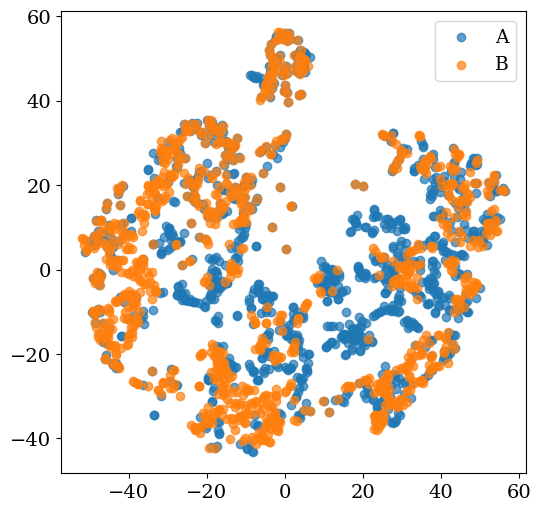

In [36]:
plt.figure(figsize=(6,6))
for model in ['A','B']:
    idx = [i for i,m in enumerate(all_meta) if m['model']==model]
    plt.scatter(X_tsne[idx,0], X_tsne[idx,1], label=model, alpha=0.7)
plt.legend()
plt.show()